## Setup and Data Preparation


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 8.6 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=7b3f0ce276642af7a17d9e150b8a76712aebd163ecdb17f03d00e4701379f255
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [ ]:
# For survival analysis
from lifelines import KaplanMeierFitter, CoxPHFitter


In [ ]:
# For model & explainability
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import shap

In [ ]:
# Load dataset
data = pd.read_csv('/content/data.csv')


In [ ]:
# Basic data cleaning and preprocessing
data.dropna(inplace=True)

In [ ]:
# Add synthetic survival info for demo
np.random.seed(42)
data['survival_time'] = np.random.exponential(scale=365*2, size=len(data))  # days
data['event'] = np.random.binomial(1, 0.3, size=len(data))  # 1=death, 0=censored

## Exploratory Data Analysis

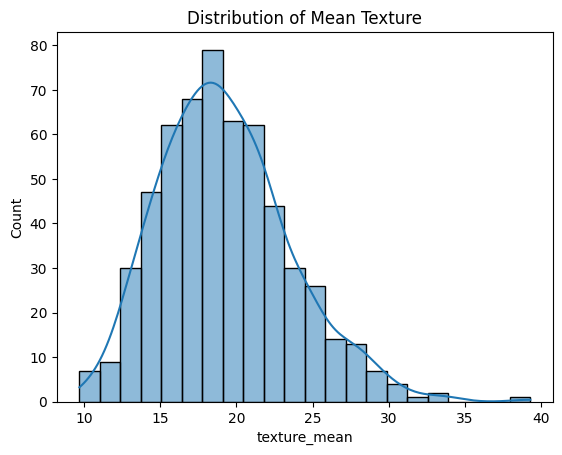

In [ ]:
# Visualize feature distributions
sns.histplot(data['texture_mean'], kde=True)
plt.title('Distribution of Mean Texture')
plt.show()

/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


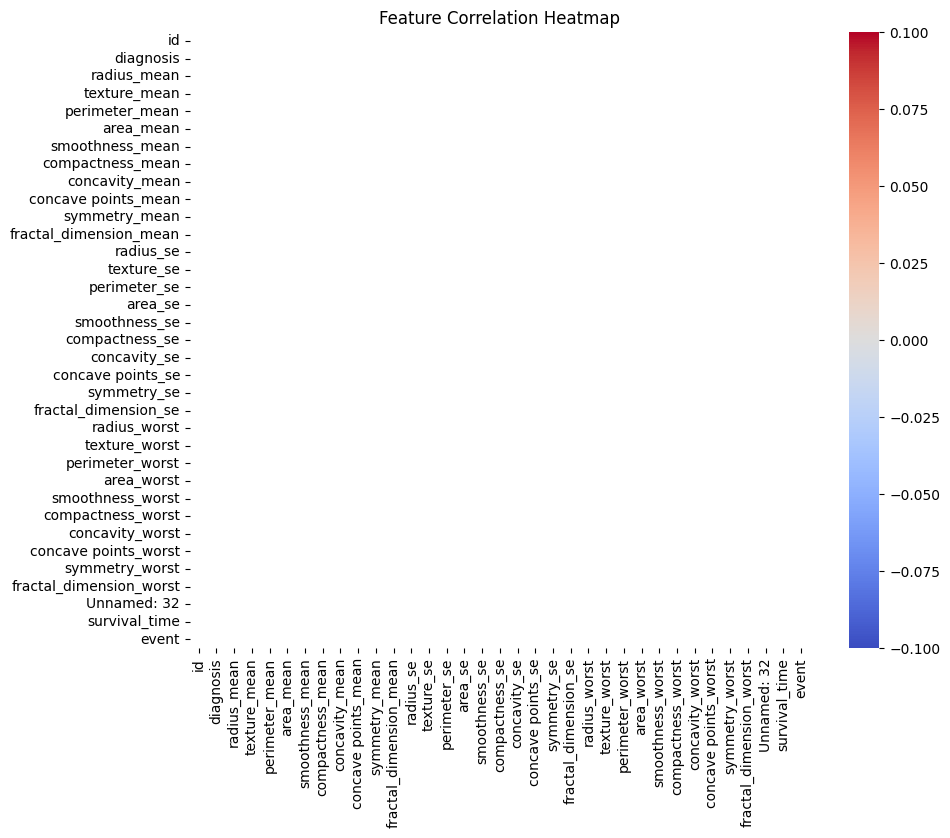

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

## Survival Analysis

In [ ]:
kmf = KaplanMeierFitter()

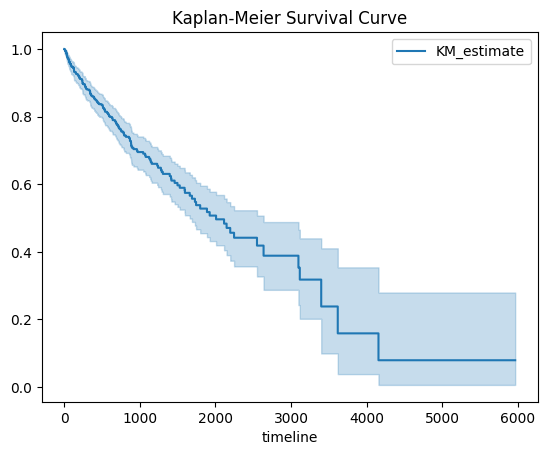

In [ ]:
# Fit Kaplan-Meier curve for entire cohort
kmf.fit(durations=data['survival_time'], event_observed=data['event'])
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve')
plt.show()

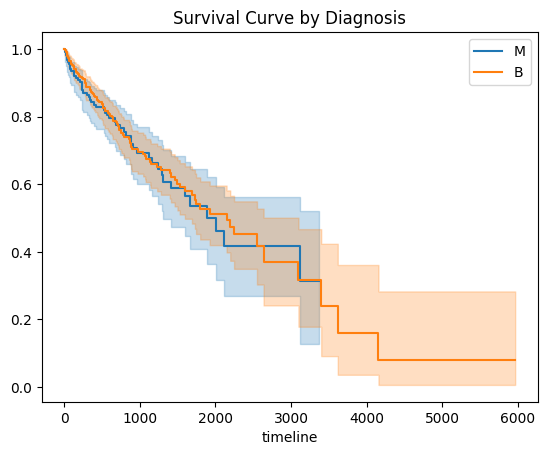

In [ ]:
# Stratify by diagnosis (malignant vs benign if available)
if 'diagnosis' in data.columns:
    for group in data['diagnosis'].unique():
        ix = data['diagnosis'] == group
        kmf.fit(data.loc[ix, 'survival_time'], event_observed=data.loc[ix, 'event'], label=group)
        kmf.plot_survival_function()

    plt.title('Survival Curve by Diagnosis')
    plt.show()

## Cox Proportional Hazards Model

In [ ]:
cph = CoxPHFitter()

In [ ]:
# Use selected features for Cox model, e.g., 'mean radius', 'mean texture', 'age', etc.
cph.fit(data[['survival_time', 'event', 'radius_mean', 'texture_mean']], duration_col='survival_time', event_col='event')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 569 total observations, 412 right-censored observations>
             duration col = 'survival_time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 569
number of events observed = 157
   partial log-likelihood = -843.31
         time fit was run = 2025-09-08 06:27:30 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
radius_mean   0.03      1.03      0.02           -0.02            0.08                0.98                1.08
texture_mean  0.00      1.00      0.02           -0.04            0.04                0.96                1.04

              cmp to    z    p  -log2(p)
covariate                               
radius_mean     0.00 1.18 0.24      2.07
texture_mean    0.00 0.05 0.96      0.06
---
Concordance = 0.54
Partial AIC = 1690.62
log-likelihood ratio test = 1.59 on 2 df
-log2(p) of ll-ratio test = 1.15

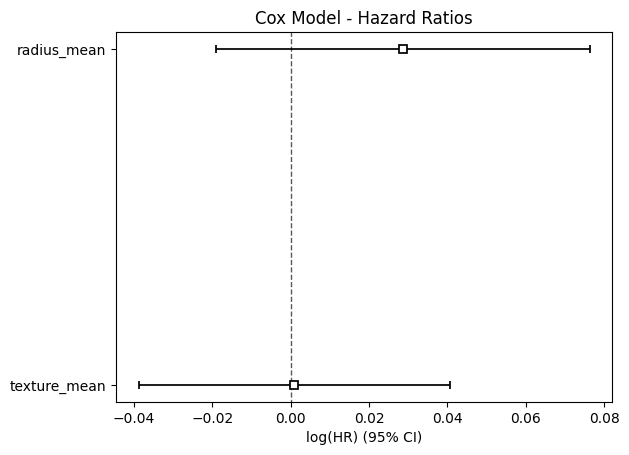

In [ ]:
# Plot hazard ratios
cph.plot()
plt.title('Cox Model - Hazard Ratios')
plt.show()

## Predictive Modeling + Explainability with SHAP

In [ ]:
# Prepare data for classification (e.g., malignant vs benign)
X = data.drop(columns=['diagnosis', 'survival_time', 'event'])
y = data['diagnosis'].map({'M':1, 'B':0})  # assuming diagnosis column with M/B

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# SHAP explainability
# Use a sample of the training data as the background dataset
background_data = X_train.sample(100, random_state=42)

explainer = shap.TreeExplainer(model, background_data)
shap_values = explainer.shap_values(X_test) # Get SHAP values for all classes

/tmp/ipython-input-1297753628.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="bar")
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


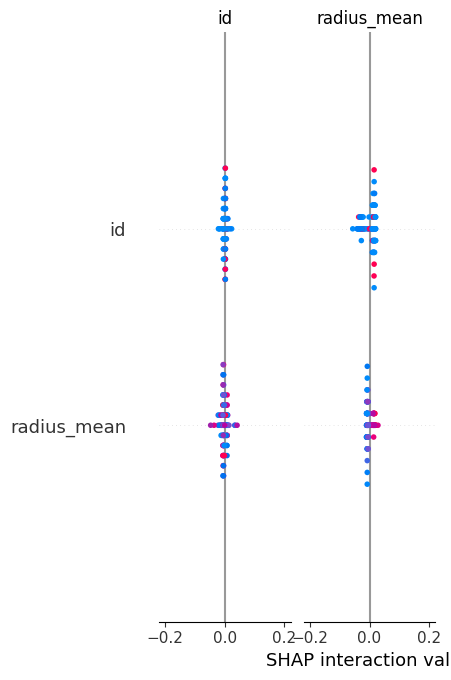

In [ ]:
# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type="bar")

## Reporting and Visualization


In [ ]:
import streamlit as st


In [ ]:
st.title('Advanced Cancer Data Analysis Dashboard')

2025-09-08 06:36:10.989 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-08 06:36:11.150 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-09-08 06:36:11.154 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-08 06:36:11.157 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


DeltaGenerator()